# Tabular methods in Reinforcement Learning

In [1]:
import gymnasium as gym
from gymnasium.spaces.discrete import Discrete
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from tqdm import tqdm
import imageio as iio

## Global config

In [2]:
'''Global configs'''
# plot configs
n_plot_step=10

# environment
cw_env = gym.make("CliffWalking-v0", render_mode='rgb_array')

fl_env_deter = gym.make("FrozenLake-v1", is_slippery=False, render_mode='rgb_array')
fl_env_slippery = gym.make("FrozenLake-v1", is_slippery=True, render_mode='rgb_array')

## Environment Setup

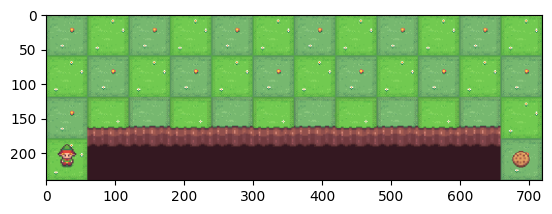

In [3]:
'''Make environment
- render_mode
    - 'human': open a live window (not interactive)
    - 'rgb_array': display an rgb image, can be rendered using plt.imshow(env.render())
'''
def render_frame(env, figsize=None):
    frame = env.render()
    figure, axis = plt.subplots(1, figsize = figsize)
    axis.imshow(frame)

# try rendering with Cliff-Walking environment
cw_env.reset()
render_frame(cw_env)

<img src="images/cliff_walking/cw_dynamic.png" width=700, height=250>

In [4]:
print(f"_____STUDY THE ENVIRONMENT_____")
n_states = cw_env.observation_space.n
print(f"Total number of observations: {n_states}")
print(f"Sample an observation from the observation space: {cw_env.observation_space.sample()}")
n_actions = cw_env.action_space.n
print(f"Total number of actions: {n_actions}")
print(f"Sample an action from the action space: {cw_env.action_space.sample()}")

_____STUDY THE ENVIRONMENT_____
Total number of observations: 48
Sample an observation from the observation space: 41
Total number of actions: 4
Sample an action from the action space: 3


- We can retrieve the dynamic of the environment, which takes the form (probabiliy, next_state, reward, terminated).
- For example, the following line of code prints out the dynamic of state 1, action 1 (move right)

In [5]:
print(fl_env_slippery.P[1][1])

[(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 5, 0.0, True), (0.3333333333333333, 2, 0.0, False)]


## Utils

In [32]:
def make_gif (env, qtable, out_dir='q-learning.gif', fps=1, max_n_steps=1000):
    '''Conduct the Q-learning policy while saving frames to make a video'''
    frames = []
    rewards = []
    state, info = env.reset()
    print(state)
    first_frame = env.render()
    frames.append(first_frame)
    n_steps = 0
    while True:
        action = greedy_policy(qtable, state)
        next_state, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        state = next_state
        frame = env.render()
        frames.append(frame)
        if terminated:
            frames.append(frame) 
            break
        if n_steps > max_n_steps:
            break
        n_steps += 1
    iio.mimsave(out_dir, [np.array(frame) for frame in frames], 'GIF')

In [ ]:
def init_qtable (n_states, n_actions):
    # return np.zeros((n_states, n_actions))
    return np.zeros((n_states, n_actions))

## Dynamic Programming

In [ ]:
def greedy_policy (qtable, state):
    actions = np.argwhere(np.array(qtable[state, :]) == np.max(qtable[state, :]))
    return np.random.choice(actions.flatten())

In [ ]:
def epsilon_greedy_policy (env, qtable, state, epsilon=0.1):
    if (np.random.rand() > epsilon):
        action = greedy_policy(qtable, state)
    else:
        action = env.action_space.sample()
    return action

- As we can see, by choosing to move to the right at state 1, the agent actually moves to the right, left, or down, each with probability of 1/3

<img src="images/frozen_lake/fl_dynamic.png" width=300, height=300>

In [7]:
def init_vtable (env):
    return np.zeros(env.observation_space.n)

def init_policy (env):
    n_states = env.observation_space.n
    n_actions = env.action_space.n    
    return np.zeros((n_states, n_actions))

In [8]:
def policy_evaluation(env, policy, n_iterations, threshold=0.01, gamma=0.9):
    vtable = init_vtable()
    delta = 0
    for i in range(n_iterations):
        for state in range(env.observation_space.n):
            old_value = vtable[state]
            new_value = 0
            for action in range(env.action_space.n):
                action_value = 0
                p_state_action = env.P[state][action]
                for possibility in p_state_action:
                    prob, new_state, reward, _ = possibility    # possbility = p(s'|s, a)
                    action_value += prob * (reward + gamma*vtable[new_state])
                new_value += policy[state, action] * action_value
            delta = max(delta, np.abs(new_value - old_value))
        if (delta < threshold): break
    return vtable

In [9]:
def policy_improvement(env, vtable, gamma=0.9):
    '''Here we assume that our policy is deterministic'''
    policy = init_policy(env)
    for state in range(env.observation_space.n):
        action_values = []
        for action in range(env.action_space.n):
            action_value = 0
            p_state_action = env.P[state][action]
            for possibility in p_state_action:
                prob, new_state, reward, _ = possibility
                action_value += prob * (reward + gamma*vtable[new_state])
            action_values.append(action_value)
        best_action = np.argmax(np.array(action_values))
        policy[state][best_action] = 1
    return policy

In [10]:
def policy_iteration(env, threshold=0.01):
    arb_policy = init_policy(env)
    arb_policy[:][0] = 1
    policy = arb_policy
    vtable = init_vtable(env)
    while True:
        old_vtable = vtable
        vtable = policy_evaluation(env, policy)
        policy = policy_improvement(env, vtable)
        delta_vtable = np.sum(np.abs(old_vtable - vtable))
        if (delta_vtable < threshold): break
    return policy

In [11]:
def value_iteration (env, threshold=1e-5, gamma=0.95):
    vtable = init_vtable(env)
    while True:
        delta = 0
        for state in range(env.observation_space.n):
            old_state_value = vtable[state]
            state_action_values = []
            for action in range(env.action_space.n):
                p_state_action = env.P[state][action]
                state_action_value = 0
                for possibility in p_state_action:
                    prob, next_state, reward, done = possibility
                    state_action_value += prob * (reward + gamma*vtable[next_state])
                state_action_values.append(state_action_value)
            new_state_value = np.max(np.array(state_action_values))
            vtable[state] = new_state_value
            new_delta = np.abs(new_state_value - old_state_value)
            delta = np.maximum(delta, new_delta)
        if delta < threshold: break
    print(f"Finish calculating value table!")
    policy = init_policy(env)
    for state in range(env.observation_space.n):
        state_action_values = []
        for action in range(env.action_space.n):
            p_state_action = env.P[state][action]
            state_action_value = 0
            for possibility in p_state_action:
                prob, next_state, reward, done = possibility
                state_action_value += prob * (reward + gamma*vtable[next_state])
            state_action_values.append(state_action_value)
        best_action = np.argmax(state_action_values)
        policy[state][best_action] = 1
    return vtable, policy   

In [12]:
def visualize_vtable(env, vtable, policy, map_height, map_width):
    directions = []
    action_arrow_mapping = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    for state in range(env.observation_space.n):
        directions.append(action_arrow_mapping[np.argmax(policy[state])])
        # directions.append(np.argmax(policy[state]))
    directions = np.array(directions, dtype=str).reshape(map_height, map_width)
    sns.heatmap(vtable.reshape(map_height, map_width), 
            annot=directions, 
            fmt='',
            annot_kws={"fontsize": "xx-large"},)

vtable, policy = value_iteration()
visualize_vtable(vtable, policy)

Hmmm... You may notice that something's a little bit... off! Why do we want to go "left" in state 0 but not "right" or "down"? First, let's print out the value table:

Finish calculating value table!


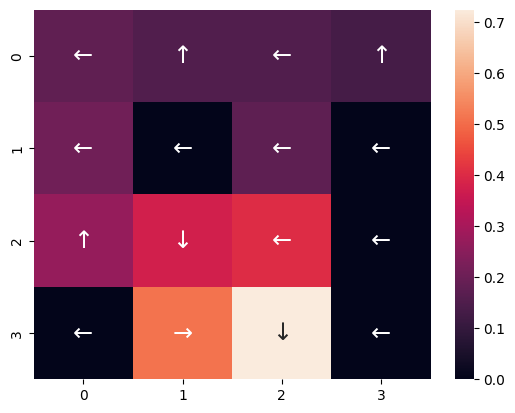

In [13]:
vtable, policy = value_iteration(fl_env_slippery)
map_height = map_width = int(np.sqrt(fl_env_slippery.observation_space.n))
visualize_vtable(fl_env_slippery, vtable, policy, map_height, map_width)

In [14]:
print(vtable)

[0.18039012 0.15469372 0.15343524 0.13250279 0.20890033 0.
 0.1764108  0.         0.27040866 0.37462244 0.40365378 0.
 0.         0.50896041 0.72366405 0.        ]


According to this value table, the value of state 4 is greater than that of state 1, which means that we should move "down" when we are in state 0. Let's next inspect the environment dynamic at state 0 when we respectively go "left", "down", "right" and "up"

In [15]:
print(fl_env_slippery.P[0])

{0: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 4, 0.0, False)], 1: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 4, 0.0, False), (0.3333333333333333, 1, 0.0, False)], 2: [(0.3333333333333333, 4, 0.0, False), (0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False)], 3: [(0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False)]}


We can observe that when we move "left", there's a 66% chance that we will end up in the same state, and 33% chance that we will end up in state 4 (which is equivalent to going "down" if our environment is not "slippery"). But when we move "right" or "down", there is an equal chance that we will end up in state 0, 1, and 4. And if you look closer to the value table, the value of state 0 is indeed, greater than that of state 1, which means that we'd rather stay in the same state than transfer to the state on the right! The policy now totally makes sense, right?

Just for the sake of sanity check, the environment's dynamic when it's deterministic (or not slippery) is either 1 or 0 for p(s'|s,a)

In [16]:
print(fl_env_deter.P[0])

{0: [(1.0, 0, 0.0, False)], 1: [(1.0, 4, 0.0, False)], 2: [(1.0, 1, 0.0, False)], 3: [(1.0, 0, 0.0, False)]}


## Monte Carlo

Tuple(Discrete(32), Discrete(11), Discrete(2))


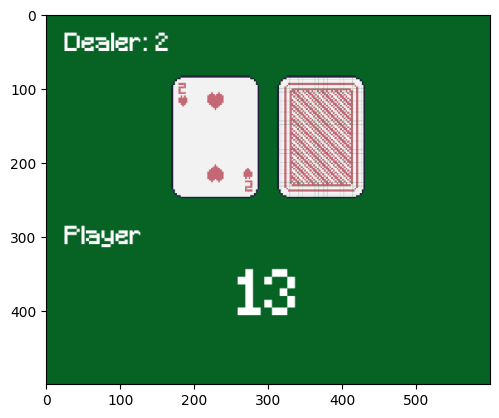

In [17]:
bj_env = gym.make("Blackjack-v1", render_mode='rgb_array')  # save for later use
bj_env.reset()
render_frame(bj_env)
print(bj_env.observation_space)
state = bj_env.observation_space.sample()
# print(bj_env.P[state])  # this will return an error that BJ environment doesn't have attribute 'P'

In [18]:
'''Make a wrapper class for exploring start'''
from gymnasium.envs.toy_text.taxi import TaxiEnv

class TaxiESEnv(TaxiEnv):
    def __init__(self, render_mode: str | None = None):
        super().__init__(render_mode)

    def reset_random(self, seed = None):
        super().reset(seed=seed)
        self.s = np.random.randint(self.observation_space.n)
        self.lastaction = None
        self.taxi_orientation = 0

        if self.render_mode == "human":
            self.render()
        return int(self.s), {"prob": 1.0, "action_mask": self.action_mask(self.s)}

(42, {'prob': 1.0, 'action_mask': array([1, 0, 1, 0, 0, 0], dtype=int8)})


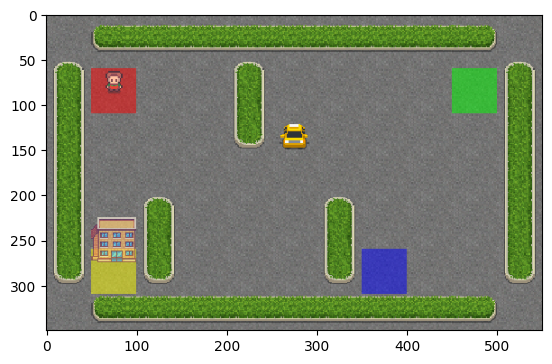

In [19]:
taxi_ES = TaxiESEnv(render_mode="rgb_array")
observation = taxi_ES.reset_random()
print(observation)
observation, reward, terminated, truncated, info = taxi_ES.step(0)

render_frame(taxi_ES)

In [20]:
def calc_n_states_actions (env):
    if (isinstance(env.observation_space, Discrete)):
        return env.observation_space.n, env.action_space.n
    else:
        n_states = 1
        for dim in env.observation_space:
            n_states *= dim.n
        print(n_states)
        n_actions = env.action_space.n
        return n_states, n_actions        

n_states, n_actions = calc_n_states_actions (cw_env)

- We can retrieve the dynamic of the environment, which takes the form (probabiliy, next_state, reward, terminated).
- For example, the following line of code prints out the dynamic of state 1, action 1 (move right)

In [21]:
def init_returns_table(env):
    pass

In [44]:
def MC_exploring_start(env: gym.Env, n_episodes: int, gamma: float = 0.9, n_max_steps=1e5):
    '''
    - The policy is deterministic
    '''
    policy = init_policy(env)
    qtable = init_qtable(env.observation_space.n, env.action_space.n)
    print(qtable.shape)
    cancel_episode = False
    for episode in tqdm(range(n_episodes)):
        rewards = []
        state_action_pairs = []
        visited_state_mask = np.zeros((500))
        state, info = env.reset_random()                            # init state randomly
        start = True
        n_steps = 0
        while True:
            n_steps += 1
            if (start):
                action = np.random.randint(0, env.action_space.n)   # init action randomly
                start = False
            else:
                action = greedy_policy(qtable, state)
            state_action_pairs.append((state, action))
            state, reward, terminated, truncated, info = env.step(action)
            if visited_state_mask[state] == 1:
                rewards.append((reward, False))
            else:
                rewards.append((reward, True))
                visited_state_mask[state] = 1
            if terminated: break
            if n_steps > n_max_steps:
                cancel_episode = True
                break
        if cancel_episode:
            cancel_episode = False
            continue
        returns = []                                                # init return table used to store returns of every state-action pair
        for i in range(env.observation_space.n):
            returns.append([[] for _ in range(env.action_space.n)])
        return_val = 0  
        for i in range(len(rewards) - 1, -1, -1):
            reward, first_visit = rewards[i]
            return_val = gamma*return_val + reward
            if first_visit:
                returns[state][action].append(return_val)
                qtable[state][action] = np.mean(returns[state][action])
                policy[state, :] = 0
                policy[state][np.argmax(qtable[state])] = 1
    return policy

In [48]:
policy = MC_exploring_start(taxi_ES, n_episodes=int(1e6))       # 1e6 eps -> 20 mins

(500, 6)


  1%|          | 8005/1000000 [14:30<22:14:44, 12.39it/s] 

In [46]:
make_gif(taxi_ES, policy, out_dir="MC.gif")

486


In [ ]:
def on_policy_epsilon_soft_MC(env, policy, n_episodes):
    '''
    - This algo is used to predict value of every state in the state space, given a policy
    '''
    policy = init_policy(env)
    returns = init_returns_table(env)

    for i in tqdm(range(n_episodes)):
        state, info = env.reset()
        
        while True:

            action = epsilon_greedy_policy(policy[state])
            if terminated: break
    

## Temporal Difference Learning (TD)

## SARSA

## Q-Learning

<img src=qlearning_algo.png width=800, height=350>

In [ ]:
def q_learning (env, n_episodes=100000, epsilon=0.1, lr=0.1, gamma=0.9, n_plot_steps=100):
    step = n_episodes // n_plot_steps
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    qtable = init_qtable(n_states, n_actions)
    metadata = {}

    plot_episodes = []
    plot_rewards = []

    for episode in tqdm(range(n_episodes)):
        state, info = env.reset()
        while True:
            action = epsilon_greedy_policy(qtable, state, epsilon)
            new_state, reward, terminated, truncated, info = env.step(action)

            # update qtable
            qtable[state, action] = qtable[state,action] + lr * (reward + gamma*np.max(qtable[new_state, :] - qtable[state, action]))

            state = new_state

            if (episode % step == 0): 
                plot_episodes.append(episode)
                plot_rewards.append(reward)
            if (terminated): break
    metadata['plot_episode'] = plot_episodes
    metadata['plot_reward'] = plot_rewards
    return qtable, metadata

In [ ]:
learned_qtable, metadata = q_learning(env)

100%|██████████| 100000/100000 [00:11<00:00, 8939.74it/s]


[[ 2.10950772  2.10950772  2.10950772  2.10950772]
 [ 2.10950772  1.14556725  2.10950772  2.10950772]
 [ 2.10950772  2.10950772  2.10950772  2.10950772]
 [ 2.10950772  2.10950772  2.10950772  2.10950772]
 [ 2.10633052  1.7363044   1.14405289  2.10950772]
 [-1.58480518 -0.639674    0.10577207  1.14556725]
 [ 1.14556725  2.10950772  2.10950772  2.10950772]
 [ 0.12813044  0.93473577  2.10950772 -1.97444289]
 [ 1.09864688  1.82779414  1.14556725  0.94529676]
 [ 1.11551315  1.02399678  1.60385918  1.14556725]
 [ 1.26206039  1.76441558  1.69443595  2.10950772]
 [ 1.72803268 -0.71082072  0.74352476  0.85629334]
 [-0.94993052  1.85272517 -0.67152821 -0.55571814]
 [ 0.87947967  0.87243963  1.80163726  0.67276383]
 [ 1.80163726  1.66248018  1.35085269  1.56024395]
 [-0.60497709  0.31708355 -1.74251612 -1.18758121]]


<Axes: >

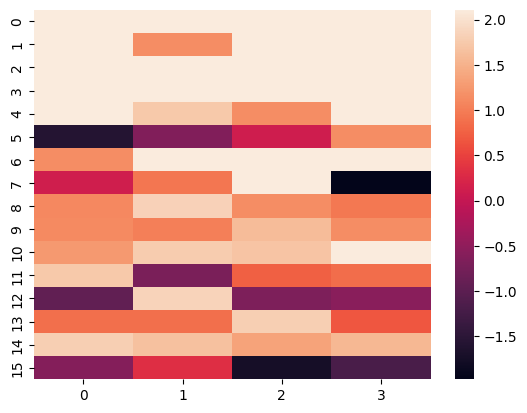

In [ ]:
print(learned_qtable)
sns.heatmap(learned_qtable)

We can notice a few things from this plot:
- Values from state 37 to 46 are 0, because these are terminal states.
- Values of the states on the right (11, 23, 35) are generally higher than values of the states on the left (0, 12, 24, 36) with respect to all actions.
- From state 25 to 34, values corresponding to the "move down" action are lower than values correspond to other actions
- When in state 36, "move right" is the least desirable action to take

## N-step Boostrapping